In [123]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [124]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [125]:
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [126]:
!unzip -q "/content/gdrive/MyDrive/final_cit_map_function.zip" 

replace per_func_map_organised_small/CoCo-.per_func.map_organised_small.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [127]:
!unzip -q "/content/gdrive/MyDrive/archive (2).zip"

replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [128]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])

In [129]:
import os
paths=[]
d = "/content/per_func_map_organised_small"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

In [130]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      text=citation_contexts[j]['citance']['text']
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/per_func_map_organised_small/PSup.per_func.map_organised_small.json
/content/per_func_map_organised_small/CoCoGM.per_func.map_organised_small.json
/content/per_func_map_organised_small/Weak.per_func.map_organised_small.json
/content/per_func_map_organised_small/Neut.per_func.map_organised_small.json
/content/per_func_map_organised_small/CoCoXY.per_func.map_organised_small.json
/content/per_func_map_organised_small/PBas.per_func.map_organised_small.json
/content/per_func_map_organised_small/CoCo-.per_func.map_organised_small.json
/content/per_func_map_organised_small/PSim.per_func.map_organised_small.json
/content/per_func_map_organised_small/PMot.per_func.map_organised_small.json
/content/per_func_map_organised_small/PModi.per_func.map_organised_small.json
/content/per_func_map_organised_small/PUse.per_func.map_organised_small.json
/content/per_func_map_organised_small/CoCoR0.per_func.map_organised_small.json
/content/per_func_map_organised_small/Future.per_func.map_organised_

In [131]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [132]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.8
val_proportion = 0.2
#test_proportion = 0.05

for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  #n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  #for item in item_list[n_train:n_train+n_val]:
   # item['split'] = 'val'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  #for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   # item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


final_citation = pd.DataFrame(final_list)

In [133]:
final_citation.isna().any()

Text_Tokens    False
Cit_func       False
citseg_id      False
split           True
dtype: bool

In [134]:
final_citation.isnull().sum()

Text_Tokens     0
Cit_func        0
citseg_id       0
split          10
dtype: int64

In [135]:
final_citation=final_citation.dropna()

In [136]:
print(type(final_citation))

<class 'pandas.core.frame.DataFrame'>


In [137]:
display(final_citation.Cit_func.value_counts())                   # Inspecting the Number of Ratings.
print(" ")

Neut      1475
PUse       761
CoCoGM     300
PMot       290
PSim       210
Weak       160
CoCoXY     156
PBas       101
PSup       100
CoCoR0     100
Future      85
CoCo-       80
PModi       65
Name: Cit_func, dtype: int64

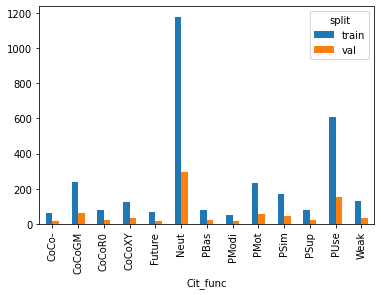

In [138]:
final_citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=final_citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [139]:
final_citation.groupby(['Cit_func','split']).size()

Cit_func  split
CoCo-     train      64
          val        16
CoCoGM    train     240
          val        60
CoCoR0    train      80
          val        20
CoCoXY    train     125
          val        31
Future    train      68
          val        17
Neut      train    1180
          val       295
PBas      train      81
          val        20
PModi     train      52
          val        13
PMot      train     232
          val        58
PSim      train     168
          val        42
PSup      train      80
          val        20
PUse      train     609
          val       152
Weak      train     128
          val        32
dtype: int64

In [140]:
# final_citation.drop(final_citation.query('Cit_func == "CoCoGM" & split == "train"').sample(n=50).index,inplace=True)

In [141]:
final_citation.drop(final_citation.query('Cit_func == "Neut" & split == "train"').sample(n=400).index,inplace=True)

In [142]:
# final_citation.drop(final_citation.query('Cit_func == "PMot" & split == "train"').sample(n=50).index,inplace=True)

In [143]:
final_citation.drop(final_citation.query('Cit_func == "PUse" & split == "train"').sample(n=200).index,inplace=True)

In [144]:
# final_citation.drop(final_citation.query('Cit_func == "Neut" & split == "val"').sample(n=100).index,inplace=True)

In [145]:
final_citation.groupby(['Cit_func','split']).size()

Cit_func  split
CoCo-     train     64
          val       16
CoCoGM    train    240
          val       60
CoCoR0    train     80
          val       20
CoCoXY    train    125
          val       31
Future    train     68
          val       17
Neut      train    780
          val      295
PBas      train     81
          val       20
PModi     train     52
          val       13
PMot      train    232
          val       58
PSim      train    168
          val       42
PSup      train     80
          val       20
PUse      train    409
          val      152
Weak      train    128
          val       32
dtype: int64

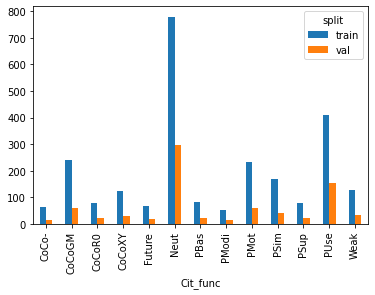

In [146]:
final_citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=final_citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

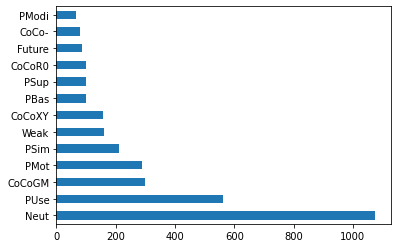

In [147]:
 final_citation.Cit_func.value_counts().plot(kind='barh')

In [148]:
display(final_citation.split.value_counts())

train    2507
val       776
Name: split, dtype: int64

In [149]:
final_citation.to_csv('final_citationteufels.csv')

In [150]:
final_citation['Cit_func'].replace({'PSim':'Comparison or Contrast','Neut':'Background','CoCoXY':'Background','Weak':'Comparison or Contrast',
                                    'CoCoGM':'Comparison or Contrast','PUse':'Uses','PBas':'Extends','PModi':'Extends','CoCoR0':'Comparison or Contrast',
                                    'PMot':'Motivation','CoCo-':'Comparison or Contrast','PSup':'Comparison or Contrast'
                                    }, inplace=True)

In [151]:
final_citation['Cit_func'].unique()

array(['Comparison or Contrast', 'Background', 'Future', 'Extends',
       'Motivation', 'Uses'], dtype=object)

In [152]:
display(final_citation.split.value_counts())

train    2507
val       776
Name: split, dtype: int64

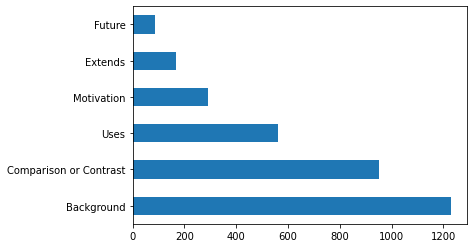

In [153]:
 final_citation.Cit_func.value_counts().plot(kind='barh')

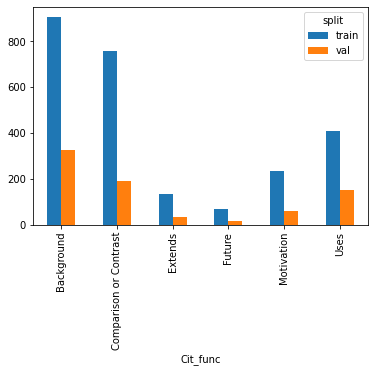

In [154]:
final_citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=final_citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [155]:
final_citation

Text_Tokens  ...  split
0                                                                                                                                                                                                                                               [Table, 2, compares, the, performance, of, our, system, on, the, setup, of, Cohen, and, CITSEG, to, the, best, results, reported, by, them, for, the, same, tasks, .]  ...  train
1                                                                                                                                                 [Our, experimental, results, show, that, the, subjectivity, classifier, performs, well, (, 77, %, recall, with, 81, %, precision, ), and, that, the, learned, nouns, improve, upon, previous, state, -, of, -, the, -, art, subjectivity, results, (, CITSEG, ), .]  ...  train
2                                                                                                                     [Regardless, of, whether, it, takes, the, form, of, dictionaries, (, CITSEG, ), ,, thesauri, (, CITSEG, ), ,, bilingual, corpora, (, CITSEG, ), ,, or, hand, -, labeled, training, sets, (, CITSEG, ), ,, providing, information, for, sense, definitions, can, be, a, considerable, burden, .]  ...  train
3     [Morphological, segmentation, decisions, in, our, model, are, delegated, to, a, lexeme, -, based, PCFG, and, we, show, that, using, a, simple, treebank, grammar, ,, a, data-driven, lexicon, ,, and, a, linguistically, motivated, unknown-, tokens, handling, our, model, outperforms, (, CITSEG, ), and, (, CITSEG, ), on, the, joint, task, and, achieves, state, -, of, -, the, -, art, results, on, a,...  ...  train
4                                                                                           [Experiments, (, Section, 5, ), show, that, forestbased, extraction, improves, BLEU, score, by, over, 1, point, on, a, state, -, of, -, the, -, art, tree, -, to, -, string, system, (, CITSEG, ), ,, which, is, also, 0.5, points, better, than, (, and, twice, as, fast, as, ), extracting, on, 30, -, best, parses, .]  ...  train
5                                                                                                                                                                                                                                                                         [We, show, that, our, system, compares, favorably, to, the, LexRank, (, CITSEG, ), baseline, in, terms, of, ROUGE, -, 1, and, ROUGE, -, 2.]  ...  train
6                                                                                                                                                                                                                                                              [Our, model, is, thus, a, simplification, of, more, sophisticated, models, which, integrate, PCFGs, with, features, ,, such, as, those, in, CITSEG, .]  ...  train
7                                                                                                                                                                                                     [Unlike, other, work, (, e.g., (, CITSEG, ), ), ,, we, treat, the, word, identities, as, a, further, refinement, of, the, POS, tags, ;, thus, we, build, a, word, classification, tree, for, each, POS, tag, .]  ...  train
8                                                                                                                                                                                                                                                                                [This, can, be, done, by, smoothing, the, observed, frequencies, 7, (, CITSEG, ), or, by, class, -, based, methods, (, CITSEG, ), .]  ...  train
9                                                                                                                                                                                                                     

In [156]:
final_citation1=pd.read_csv('/content/gdrive/MyDrive/final_citationjurgens1.csv')

In [157]:
final_citation1=final_citation1.drop(columns=['Text_Tokens','Unnamed: 0','citseg_id'])

In [158]:
final_citation1=final_citation1.rename(columns={"Citationsent":'Text_Tokens',"citseg_id1":'citseg_id'})

In [159]:
final_citation1

Text_Tokens  ...  split
0                                                                                                                                                                                         ['Table', '2', 'compares', 'the', 'performance', 'of', 'our', 'system', 'on', 'the', 'setup', 'of', 'Cohen', 'and', 'CITSEG', 'to', 'the', 'best', 'results', 'reported', 'by', 'them', 'for', 'the', 'same', 'tasks', '.']  ...  train
1                                                                 ['Our', 'experimental', 'results', 'show', 'that', 'the', 'subjectivity', 'classifier', 'performs', 'well', '(', '77', '%', 'recall', 'with', '81', '%', 'precision', ')', 'and', 'that', 'the', 'learned', 'nouns', 'improve', 'upon', 'previous', 'state', '-', 'of', '-', 'the', '-', 'art', 'subjectivity', 'results', '(', 'CITSEG', ')', '.']  ...  train
2                           ['Regardless', 'of', 'whether', 'it', 'takes', 'the', 'form', 'of', 'dictionaries', '(', 'CITSEG', ')', ',', 'thesauri', '(', 'CITSEG', ')', ',', 'bilingual', 'corpora', '(', 'CITSEG', ')', ',', 'or', 'hand', '-', 'labeled', 'training', 'sets', '(', 'CITSEG', ')', ',', 'providing', 'information', 'for', 'sense', 'definitions', 'can', 'be', 'a', 'considerable', 'burden', '.']  ...  train
3     ['Morphological', 'segmentation', 'decisions', 'in', 'our', 'model', 'are', 'delegated', 'to', 'a', 'lexeme', '-', 'based', 'PCFG', 'and', 'we', 'show', 'that', 'using', 'a', 'simple', 'treebank', 'grammar', ',', 'a', 'data-driven', 'lexicon', ',', 'and', 'a', 'linguistically', 'motivated', 'unknown-', 'tokens', 'handling', 'our', 'model', 'outperforms', '(', 'CITSEG', ')', 'and', '(', 'CITSEG...  ...  train
4     ['Experiments', '(', 'Section', '5', ')', 'show', 'that', 'forestbased', 'extraction', 'improves', 'BLEU', 'score', 'by', 'over', '1', 'point', 'on', 'a', 'state', '-', 'of', '-', 'the', '-', 'art', 'tree', '-', 'to', '-', 'string', 'system', '(', 'CITSEG', ')', ',', 'which', 'is', 'also', '0.5', 'points', 'better', 'than', '(', 'and', 'twice', 'as', 'fast', 'as', ')', 'extracting', 'on', '30'...  ...  train
5                                                                                                                                                                                                                         ['We', 'show', 'that', 'our', 'system', 'compares', 'favorably', 'to', 'the', 'LexRank', '(', 'CITSEG', ')', 'baseline', 'in', 'terms', 'of', 'ROUGE', '-', '1', 'and', 'ROUGE', '-', '2.']  ...  train
6                                                                                                                                                                                                                  ['Our', 'model', 'is', 'thus', 'a', 'simplification', 'of', 'more', 'sophisticated', 'models', 'which', 'integrate', 'PCFGs', 'with', 'features', ',', 'such', 'as', 'those', 'in', 'CITSEG', '.']  ...  train
7                                                                                                                             ['Unlike', 'other', 'work', '(', 'e.g.', '(', 'CITSEG', ')', ')', ',', 'we', 'treat', 'the', 'word', 'identities', 'as', 'a', 'further', 'refinement', 'of', 'the', 'POS', 'tags', ';', 'thus', 'we', 'build', 'a', 'word', 'classification', 'tree', 'for', 'each', 'POS', 'tag', '.']  ...  train
8                                                                                                                                                                                                                                  ['This', 'can', 'be', 'done', 'by', 'smoothing', 'the', 'observed', 'frequencies', '7', '(', 'CITSEG', ')', 'or', 'by', 'class', '-', 'based', 'methods', '(', 'CITSEG', ')', '.']  ...  train
9                                                                                                                                                                                                                     

In [160]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index#,token
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [161]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [162]:
class CitationVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title, vector_length=-1):
        """
        Args:
            title (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized title (numpy.array)
        """
        indices = [self.title_vocab.begin_seq_index]
        indices.extend(self.title_vocab.lookup_token(token) 
                       for token in title)
        indices.append(self.title_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index
        return out_vector

    @classmethod
    def from_dataframe(cls, citation_df, cutoff=0):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            citation_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the CitationVectorizer
        """
        category_vocab = Vocabulary()     
        for category in sorted(set(citation_df.Cit_func)):
            category_vocab.add_token(category)
            #a=category_vocab.add_token(category)
            #print(a)
        word_counts = Counter()
        for title in citation_df.Text_Tokens:
          # print("title is %s"%title)
          for token in title:
              # print("token is %s"%token)
              #if token not in string.punctuation:
              word_counts[token] += 1
        
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            # print("word:word_count are %s:%d"%(word,word_count))
            if word_count >= cutoff:
                title_vocab.add_token(word)
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        
        title_vocab = \
            SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab =  \
            Vocabulary.from_serializable(contents['category_vocab'])

        return cls(title_vocab=title_vocab, category_vocab=category_vocab)

    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [163]:
class CitationDataset(Dataset):
    def __init__(self, citation_df, vectorizer):
        """
        Args:
            citation_df (pandas.DataFrame): the dataset
            vectorizer (CitationVectorizer): vectorizer instatiated from dataset
        """
        self.citation_df = citation_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context)
        self._max_seq_length = max(map(measure_len, citation_df.Text_Tokens)) + 2
        

        self.train_df = self.citation_df[self.citation_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.citation_df[self.citation_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.citation_df[self.citation_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = citation_df.Cit_func.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, citation_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            citation_csv (str): location of the dataset
        Returns:
            an instance of citationDataset
        """
        citation_df = citation_csv
        train_citation_df = citation_df[citation_df.split=='train']
        return cls(citation_df, CitationVectorizer.from_dataframe(train_citation_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, citation_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        
        citation_df = citation_csv
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(citation_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of functionVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        
        
        row = self._target_df.iloc[index]
        citseg= row.citseg_id
        title_vector = \
            self._vectorizer.vectorize(row.Text_Tokens, self._max_seq_length)

        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.Cit_func)
        
        return {'x_data': title_vector,
                'y_target': category_index,
                'citseg_id':citseg
                }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 

    # print("generate batches dataset")
    # print(dataset)
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        # print('data_dict')
        # print(data_dict)
        out_data_dict = {}
        for name, tensor in data_dict.items():
            # print(name)
            # print(tensor)
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [164]:
# bilstm output of only citseg vector
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class CitationClassifier1(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_layers, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
      
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CitationClassifier1, self).__init__()
        self.hidden_dim = hidden_dim

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_size, hidden_dim,num_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim*2, 120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120, num_classes)
        self.act=nn.Softmax()
        


    def forward(self, x_in, citseg_id, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batch_size = x_in.size(0)
        h_embedding = self.emb(x_in)

        packed_output, (hidden, cell) = self.lstm(h_embedding)
        packed_output=packed_output[torch.arange(packed_output.size(0)),citseg_id.long()]
        out = self.fc1(packed_output)
        out = self.relu(out)
        out = self.fc2(out)
        pred1= self.act(out)
        return pred1

In [165]:
# bilstm(concat of citseg bilstm output + h_1 + h_n)
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class CitationClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_layers, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
      
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CitationClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_size, hidden_dim,num_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim*2*3, 120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120, num_classes)
        self.act=nn.Softmax()
        


    def forward(self, x_in, citseg_id, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        a = 0
        z = 192
        batch_size = x_in.size(0)
        h_embedding = self.emb(x_in)
        # print(h_embedding)

        packed_output, (hidden, cell) = self.lstm(h_embedding)
        h_1 = packed_output[torch.arange(packed_output.size(0)),a]
        h_n = packed_output[torch.arange(packed_output.size(0)),z]
        packed_output=packed_output[torch.arange(packed_output.size(0)),citseg_id.long()]
        h_1h_n=torch.cat([h_1,packed_output,h_n],dim=1)
        out = self.fc1(h_1h_n)
        out = self.relu(out)
        out = self.fc2(out)
        pred1= self.act(out)
        return pred1

In [166]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [167]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i
    print(final_embeddings)
    print(final_embeddings.shape)
    return final_embeddings

In [168]:
from argparse import Namespace

In [169]:
args = Namespace(
    # Data and Path hyper parameters
    citation_csv=final_citation,
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch5/document_classification",
    # Model hyper parameters
    glove_filepath='/content/glove.6B.300d.txt', 
    use_glove=False,
    embedding_size=300, 
    hidden_dim=32,
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.1, 
    batch_size=30, 
    num_epochs=30, 
    num_layers=2,
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch5/document_classification/vectorizer.json
	model_storage/ch5/document_classification/model.pth
Using CUDA: True


In [170]:
args.use_glove = True

In [171]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = CitationDataset.load_dataset_and_load_vectorizer(args.citation_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = CitationDataset.load_dataset_and_make_vectorizer(args.citation_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()
print(len(vectorizer.title_vocab))
# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

classifier = CitationClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_layers=args.num_layers,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

print(classifier)

7632
[[-0.11907164 -0.00123771  0.03475953 ...  0.10838436 -0.02188396
  -0.09059642]
 [-0.03658002  0.06027976 -0.01801901 ...  0.11394491 -0.03662597
  -0.09734906]
 [-0.07221913 -0.02466366 -0.03699218 ...  0.0299247  -0.07259606
  -0.04028996]
 ...
 [ 0.04125384  0.13328813  0.11181668 ... -0.13325182  0.04659251
   0.03860948]
 [-0.38506     0.094772    0.33281    ... -0.5335      0.2129
  -0.063519  ]
 [-0.22567     0.52341     0.27984    ... -0.27486     0.11941
  -0.34116   ]]
(7632, 300)
Using pre-trained embeddings
CitationClassifier(
  (emb): Embedding(7632, 300, padding_idx=0)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=6, bias=True)
  (act): Softmax(dim=None)
)


In [172]:
embeddings.shape

(7632, 300)

In [173]:
print(embeddings)

[[-0.11907164 -0.00123771  0.03475953 ...  0.10838436 -0.02188396
  -0.09059642]
 [-0.03658002  0.06027976 -0.01801901 ...  0.11394491 -0.03662597
  -0.09734906]
 [-0.07221913 -0.02466366 -0.03699218 ...  0.0299247  -0.07259606
  -0.04028996]
 ...
 [ 0.04125384  0.13328813  0.11181668 ... -0.13325182  0.04659251
   0.03860948]
 [-0.38506     0.094772    0.33281    ... -0.5335      0.2129
  -0.063519  ]
 [-0.22567     0.52341     0.27984    ... -0.27486     0.11941
  -0.34116   ]]


In [174]:
predictions=[]
prediction=[]
y=[]
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.RMSprop(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            _, predictions = y_pred.max(dim=1)
            prediction.append(predictions)
            y.append(batch_dict['y_target'])

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_index, running_loss, running_acc))

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        # print("Test loss: {};".format(train_state['val_loss']))
        # print("Test Accuracy: {}".format(train_state['val_acc']))

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


training routine:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	 val_loss=1.7145228290557863	 val_acc=24.53333333333333
Epoch 1	 val_loss=1.6287097549438474	 val_acc=42.8
Epoch 2	 val_loss=1.575296401977539	 val_acc=42.13333333333335
Epoch 3	 val_loss=1.5325292015075682	 val_acc=39.86666666666666
Epoch 4	 val_loss=1.5490560388565062	 val_acc=50.53333333333333
Epoch 5	 val_loss=1.5836140060424806	 val_acc=50.26666666666666
Epoch 6	 val_loss=1.5425851011276246	 val_acc=49.733333333333334
Epoch 7	 val_loss=1.534805488586426	 val_acc=53.599999999999994
Epoch 8	 val_loss=1.5388329315185547	 val_acc=53.2
Epoch 9	 val_loss=1.5520059204101562	 val_acc=52.8
Epoch 10	 val_loss=1.5350629901885986	 val_acc=53.2
Epoch 11	 val_loss=1.5598621463775635	 val_acc=51.733333333333334
Epoch 12	 val_loss=1.5561445379257204	 val_acc=52.266666666666666
Epoch 13	 val_loss=1.5472301244735716	 val_acc=52.93333333333334
Epoch 14	 val_loss=1.5501615619659426	 val_acc=52.13333333333333
Epoch 15	 val_loss=1.5493609619140625	 val_acc=53.6
Epoch 16	 val_loss=1.546350808143

In [175]:
print("val loss: {};".format(train_state['val_loss']))
print("val Accuracy: {}".format(train_state['val_acc']))

val loss: [1.7145228290557863, 1.6287097549438474, 1.575296401977539, 1.5325292015075682, 1.5490560388565062, 1.5836140060424806, 1.5425851011276246, 1.534805488586426, 1.5388329315185547, 1.5520059204101562, 1.5350629901885986, 1.5598621463775635, 1.5561445379257204, 1.5472301244735716, 1.5501615619659426, 1.5493609619140625, 1.5463508081436157, 1.548009552955627, 1.5583992624282834, 1.5480653047561648, 1.55487859249115, 1.5457071638107303, 1.5462488508224486, 1.5480728006362914, 1.5591506719589232, 1.5532380437850954, 1.5595530462265013, 1.5437433576583863, 1.5478352403640745, 1.5640746259689333];
val Accuracy: [24.53333333333333, 42.8, 42.13333333333335, 39.86666666666666, 50.53333333333333, 50.26666666666666, 49.733333333333334, 53.599999999999994, 53.2, 52.8, 53.2, 51.733333333333334, 52.266666666666666, 52.93333333333334, 52.13333333333333, 53.6, 53.86666666666667, 53.33333333333333, 53.06666666666666, 52.53333333333333, 52.8, 52.8, 52.666666666666664, 53.06666666666666, 52.53333

In [176]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
predictions=[]
prediction=[]
y=[]



for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    _, predictions = y_pred.max(dim=1)
    prediction.append(predictions)
    y.append(batch_dict['y_target'])
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [177]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [178]:
true_y=y_tensor.cpu().detach().numpy()

In [179]:
pred_y=pred_tensor.cpu().detach().numpy()

In [180]:
pred_y=pred_y.flatten()

In [181]:
true_y=true_y.flatten()

In [182]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.60      0.56      0.58       314
Comparison or Contrast       0.45      0.53      0.49       187
               Extends       0.26      0.28      0.27        32
                Future       0.55      0.40      0.46        15
            Motivation       0.35      0.41      0.38        56
                  Uses       0.69      0.57      0.62       146

              accuracy                           0.53       750
             macro avg       0.48      0.46      0.47       750
          weighted avg       0.54      0.53      0.53       750



In [183]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [184]:
cf_matrix

array([[176,  79,   9,   2,  26,  22],
       [ 53, 100,   8,   2,  11,  13],
       [  9,  12,   9,   0,   1,   1],
       [  2,   4,   0,   6,   2,   1],
       [ 16,  15,   1,   0,  23,   1],
       [ 37,  14,   8,   1,   3,  83]])

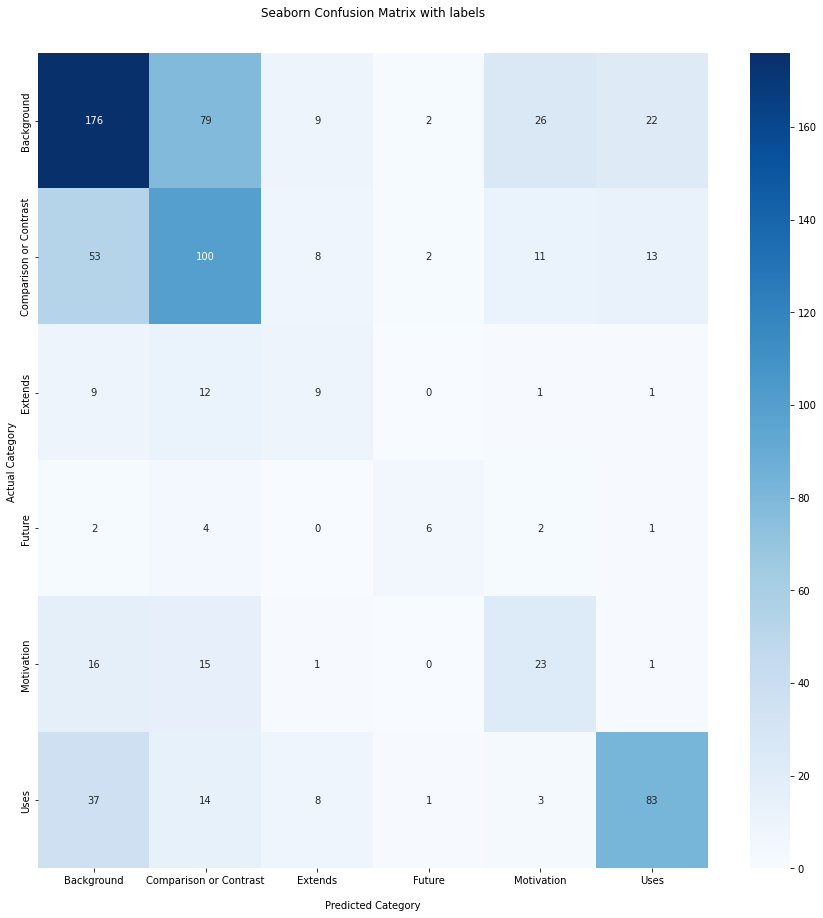

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [186]:
classifier = CitationClassifier1(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_layers=args.num_layers,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

print(classifier)

CitationClassifier1(
  (emb): Embedding(7632, 300, padding_idx=0)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=6, bias=True)
  (act): Softmax(dim=None)
)


In [187]:
predictions=[]
prediction=[]
y=[]
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.RMSprop(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            _, predictions = y_pred.max(dim=1)
            prediction.append(predictions)
            y.append(batch_dict['y_target'])

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_index, running_loss, running_acc))

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        # print("Test loss: {};".format(train_state['val_loss']))
        # print("Test Accuracy: {}".format(train_state['val_acc']))

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


training routine:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	 val_loss=1.7610935640335084	 val_acc=26.266666666666666
Epoch 1	 val_loss=1.707458653450012	 val_acc=28.133333333333333
Epoch 2	 val_loss=1.6819124650955197	 val_acc=35.199999999999996
Epoch 3	 val_loss=1.6471621227264404	 val_acc=40.93333333333333
Epoch 4	 val_loss=1.6357924222946167	 val_acc=36.266666666666666
Epoch 5	 val_loss=1.610821352005005	 val_acc=41.199999999999996
Epoch 6	 val_loss=1.6017411041259766	 val_acc=40.800000000000004
Epoch 7	 val_loss=1.6168733978271486	 val_acc=44.53333333333333
Epoch 8	 val_loss=1.6330128335952758	 val_acc=44.800000000000004
Epoch 9	 val_loss=1.6360596895217894	 val_acc=47.46666666666667
Epoch 10	 val_loss=1.6183865928649903	 val_acc=47.333333333333336
Epoch 11	 val_loss=1.6279488134384152	 val_acc=48.53333333333333
Epoch 12	 val_loss=1.6425546836853029	 val_acc=46.00000000000001
Epoch 13	 val_loss=1.6229432868957518	 val_acc=48.00000000000001
Epoch 14	 val_loss=1.6339708614349364	 val_acc=49.46666666666666
Epoch 15	 val_loss=1.61886750

In [188]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
predictions=[]
prediction=[]
y=[]

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    _, predictions = y_pred.max(dim=1)
    prediction.append(predictions)
    y.append(batch_dict['y_target'])
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [189]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [190]:
true_y=y_tensor.cpu().detach().numpy()

In [191]:
pred_y=pred_tensor.cpu().detach().numpy()

In [192]:
pred_y=pred_y.flatten()

In [193]:
true_y=true_y.flatten()

In [194]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.60      0.55      0.57       312
Comparison or Contrast       0.44      0.51      0.47       185
               Extends       0.20      0.16      0.18        32
                Future       0.11      0.31      0.16        16
            Motivation       0.47      0.35      0.40        57
                  Uses       0.52      0.45      0.48       148

              accuracy                           0.49       750
             macro avg       0.39      0.39      0.38       750
          weighted avg       0.50      0.49      0.49       750



In [195]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

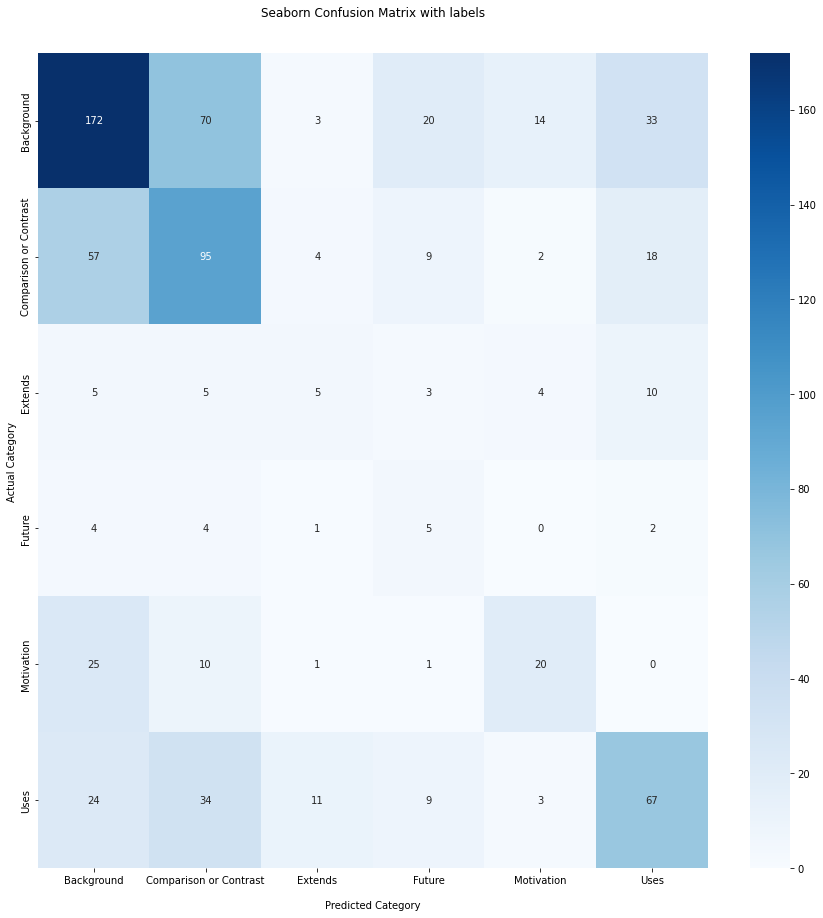

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [197]:
#if you could generate a global attentive sentence vector and use that for classsification
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        # print("x.shape")
        # print(x.shape)
        feature_dim = self.feature_dim 
        # print(feature_dim)
        step_dim = self.step_dim
        # print(step_dim)

        eij = torch.mm(x.contiguous().view(-1, feature_dim), self.weight).view(-1, step_dim)
        # print("eij.shape")
        # print(eij.shape)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        sum= torch.sum(weighted_input, 1)
        return sum

class CitationClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_layers, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
      
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CitationClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_size, hidden_dim,num_layers, bidirectional=True, batch_first=True)
        self.attention_layer = Attention(hidden_dim*2, 193)
        self.fc1 = nn.Linear(hidden_dim*2, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, num_classes)
        self.act=nn.Softmax()
        


    def forward(self, x_in, citseg_id, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batch_size = x_in.size(0)
        seq_length =  x_in.size(1)
        h_embedding = self.emb(x_in)
        # print(h_embedding.shape) 
        packed_output, (hidden, cell) = self.lstm(h_embedding)
        # print(packed_output.shape)
        packed_output = self.attention_layer(packed_output)
        #packed_output=packed_output[torch.arange(packed_output.size(0)),citseg_id.long()]
        #h_1h_n=torch.cat([packed_output,packed_output1],dim=1)
        out = self.fc1(packed_output)
        # print(out.shape)
        out = self.relu(out)
        # print(out.shape)
        out = self.fc2(out)
        # print(out.shape)
        pred1= self.act(out)
        # print(pred1.shape)
        return pred1

In [198]:
classifier = CitationClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_layers=args.num_layers,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

print(classifier)

CitationClassifier(
  (emb): Embedding(7632, 300, padding_idx=0)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention_layer): Attention()
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (act): Softmax(dim=None)
)


In [199]:
predictions=[]
prediction=[]
y=[]
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.RMSprop(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()
            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            _, predictions = y_pred.max(dim=1)
            prediction.append(predictions)
            y.append(batch_dict['y_target'])

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_index, running_loss, running_acc))

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        # print("Test loss: {};".format(train_state['val_loss']))
        # print("Test Accuracy: {}".format(train_state['val_acc']))

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


training routine:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	 val_loss=1.7918512392044064	 val_acc=24.400000000000002
Epoch 1	 val_loss=1.7596468734741213	 val_acc=11.33333333333333
Epoch 2	 val_loss=1.7502846240997312	 val_acc=8.933333333333334
Epoch 3	 val_loss=1.6885511255264283	 val_acc=21.6
Epoch 4	 val_loss=1.6916031360626222	 val_acc=18.13333333333333
Epoch 5	 val_loss=1.6371483993530274	 val_acc=34.933333333333344
Epoch 6	 val_loss=1.6385527276992795	 val_acc=37.599999999999994
Epoch 7	 val_loss=1.599588346481323	 val_acc=42.400000000000006
Epoch 8	 val_loss=1.5833448123931886	 val_acc=46.0
Epoch 9	 val_loss=1.5791409063339232	 val_acc=48.0
Epoch 10	 val_loss=1.6043728017807009	 val_acc=42.666666666666664
Epoch 11	 val_loss=1.6022526502609253	 val_acc=42.13333333333334
Epoch 12	 val_loss=1.5829645252227782	 val_acc=45.733333333333334
Epoch 13	 val_loss=1.6095336532592777	 val_acc=47.86666666666667
Epoch 14	 val_loss=1.595216612815857	 val_acc=48.4
Epoch 15	 val_loss=1.5905220556259154	 val_acc=49.33333333333333
Epoch 16	 val_loss

In [200]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
predictions=[]
prediction=[]
y=[]

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    _, predictions = y_pred.max(dim=1)
    prediction.append(predictions)
    y.append(batch_dict['y_target'])
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [201]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [202]:
true_y=y_tensor.cpu().detach().numpy()

In [203]:
pred_y=pred_tensor.cpu().detach().numpy()

In [204]:
pred_y=pred_y.flatten()

In [205]:
true_y=true_y.flatten()

In [206]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.59      0.48      0.53       317
Comparison or Contrast       0.41      0.50      0.45       182
               Extends       0.21      0.31      0.25        32
                Future       0.62      0.33      0.43        15
            Motivation       0.47      0.41      0.44        58
                  Uses       0.48      0.55      0.51       146

              accuracy                           0.48       750
             macro avg       0.47      0.43      0.44       750
          weighted avg       0.50      0.48      0.49       750



In [207]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

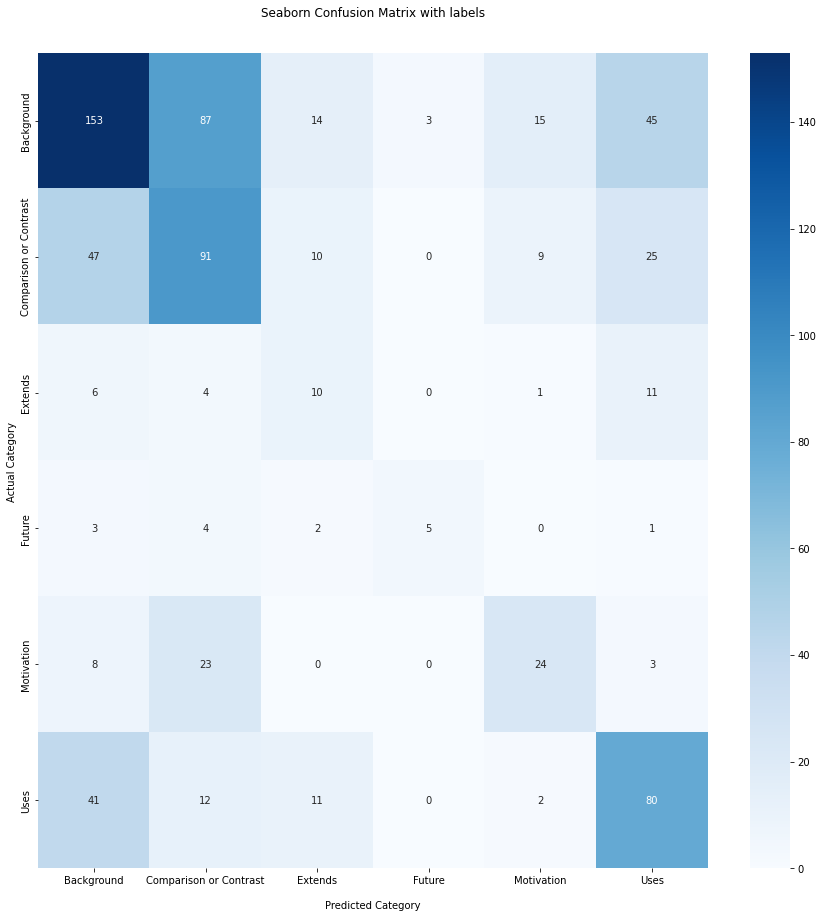

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [209]:
#f you could append that attentive sentence vector to CITSEG and send the new feature vector to classification
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        # print("x.shape")
        # print(x.shape)
        feature_dim = self.feature_dim 
        # print(feature_dim)
        step_dim = self.step_dim
        # print(step_dim)

        eij = torch.mm(x.contiguous().view(-1, feature_dim), self.weight).view(-1, step_dim)
        # print("eij.shape")
        # print(eij.shape)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        sum= torch.sum(weighted_input, 1)
        return sum

class CitationClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_layers, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
      
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CitationClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_size, hidden_dim,num_layers, bidirectional=True, batch_first=True)
        self.attention_layer = Attention(hidden_dim*2, 193)
        self.fc1 = nn.Linear(hidden_dim*4, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, num_classes)
        self.act=nn.Softmax()
        


    def forward(self, x_in, citseg_id, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batch_size = x_in.size(0)
        seq_length =  x_in.size(1)
        h_embedding = self.emb(x_in)
        # print(h_embedding.shape) 
        packed_output, (hidden, cell) = self.lstm(h_embedding)
        packed_output1 = self.attention_layer(packed_output)
        packed_output2 = packed_output[torch.arange(packed_output.size(0)),citseg_id.long()]
        #packed_output1=packed_output1.view(30,1)
        att_citeseg=torch.cat([packed_output1,packed_output2],dim=1)
        out = self.fc1(att_citeseg)
        # print(out.shape)
        out = self.relu(out)
        # print(out.shape)
        out = self.fc2(out)
        # print(out.shape)
        pred1= self.act(out)
        # print(pred1.shape)
        return pred1

In [210]:
classifier = CitationClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_layers=args.num_layers,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

print(classifier)

CitationClassifier(
  (emb): Embedding(7632, 300, padding_idx=0)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention_layer): Attention()
  (fc1): Linear(in_features=128, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (act): Softmax(dim=None)
)


In [211]:
predictions=[]
prediction=[]
y=[]
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.RMSprop(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()
            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            _, predictions = y_pred.max(dim=1)
            prediction.append(predictions)
            y.append(batch_dict['y_target'])

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_index, running_loss, running_acc))

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        # print("Test loss: {};".format(train_state['val_loss']))
        # print("Test Accuracy: {}".format(train_state['val_acc']))

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


training routine:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	 val_loss=1.782224988937378	 val_acc=17.466666666666665
Epoch 1	 val_loss=1.7072236633300781	 val_acc=24.666666666666668
Epoch 2	 val_loss=1.6612168455123901	 val_acc=32.13333333333334
Epoch 3	 val_loss=1.5907049751281739	 val_acc=41.86666666666667
Epoch 4	 val_loss=1.5994598245620726	 val_acc=44.53333333333333
Epoch 5	 val_loss=1.5987595176696778	 val_acc=48.26666666666666
Epoch 6	 val_loss=1.5520772361755373	 val_acc=52.66666666666666
Epoch 7	 val_loss=1.5394319629669189	 val_acc=53.46666666666666
Epoch 8	 val_loss=1.5390973901748657	 val_acc=55.066666666666656
Epoch 9	 val_loss=1.5368894815444947	 val_acc=54.533333333333324
Epoch 10	 val_loss=1.5445233821868893	 val_acc=54.26666666666667
Epoch 11	 val_loss=1.5340564775466916	 val_acc=53.33333333333334
Epoch 12	 val_loss=1.5420185422897341	 val_acc=53.33333333333333
Epoch 13	 val_loss=1.5454790449142457	 val_acc=54.8
Epoch 14	 val_loss=1.55487380027771	 val_acc=53.19999999999999
Epoch 15	 val_loss=1.543377161026001	 val_acc=5

In [212]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
predictions=[]
prediction=[]
y=[]

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    _, predictions = y_pred.max(dim=1)
    prediction.append(predictions)
    y.append(batch_dict['y_target'])
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [213]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [214]:
true_y=y_tensor.cpu().detach().numpy()

In [215]:
pred_y=pred_tensor.cpu().detach().numpy()

In [216]:
pred_y=pred_y.flatten()

In [217]:
true_y=true_y.flatten()

In [218]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.57      0.60      0.58       315
Comparison or Contrast       0.55      0.62      0.59       184
               Extends       0.24      0.30      0.27        33
                Future       0.35      0.41      0.38        17
            Motivation       0.45      0.42      0.43        55
                  Uses       0.65      0.45      0.53       146

              accuracy                           0.55       750
             macro avg       0.47      0.47      0.46       750
          weighted avg       0.55      0.55      0.55       750



In [219]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

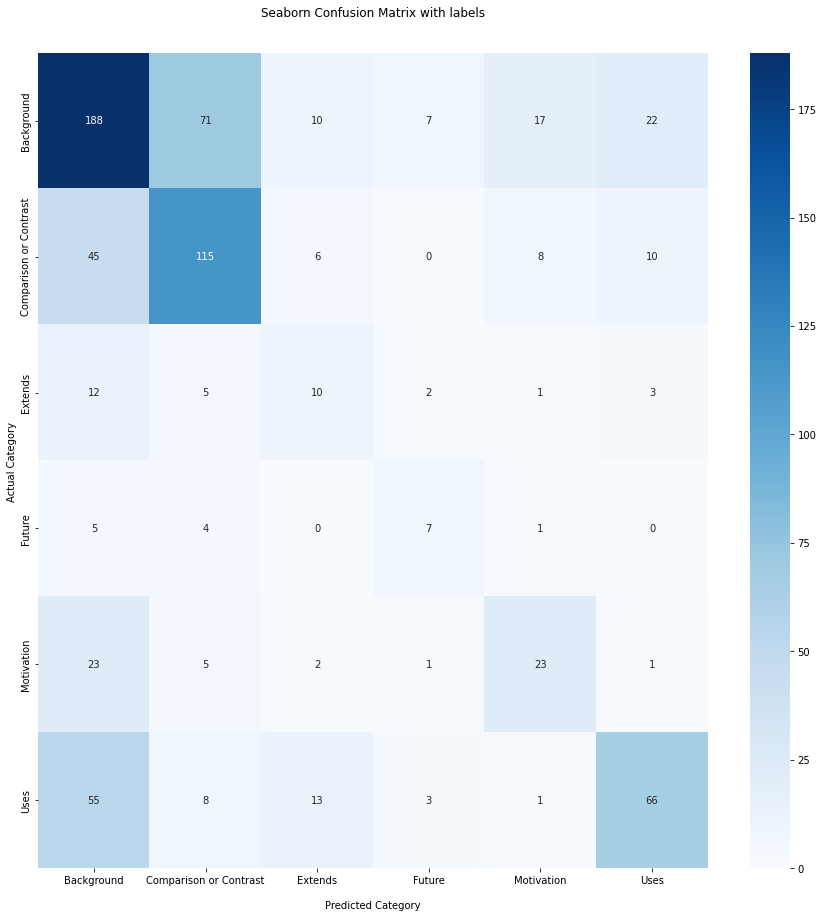

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [221]:
#whether you can replace the sentence vector with max pooling of the sentence (as the sentence vector)
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class CitationClassifier1(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_layers, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
      
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CitationClassifier1, self).__init__()
        self.hidden_dim = hidden_dim

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_size, hidden_dim,num_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim*2, 120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120, num_classes)
        self.act=nn.Softmax()
        


    def forward(self, x_in, citseg_id, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        a = 0
        z = 192
        batch_size = x_in.size(0)
        h_embedding = self.emb(x_in)

        packed_output, (hidden, cell) = self.lstm(h_embedding)
        packed_output = torch.max(packed_output,1)
        #packed_output=packed_output[torch.arange(packed_output.size(0)),citseg_id.long()]
        out = self.fc1(packed_output)
        out = self.relu(out)
        out = self.fc2(out)
        pred1= self.act(out)
        return pred1

In [222]:
classifier = CitationClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_layers=args.num_layers,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

print(classifier)

CitationClassifier(
  (emb): Embedding(7632, 300, padding_idx=0)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention_layer): Attention()
  (fc1): Linear(in_features=128, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (act): Softmax(dim=None)
)


In [223]:
predictions=[]
prediction=[]
y=[]
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.RMSprop(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()
            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            _, predictions = y_pred.max(dim=1)
            prediction.append(predictions)
            y.append(batch_dict['y_target'])

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_index, running_loss, running_acc))

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        # print("Test loss: {};".format(train_state['val_loss']))
        # print("Test Accuracy: {}".format(train_state['val_acc']))

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


training routine:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	 val_loss=1.7546906805038456	 val_acc=21.46666666666667
Epoch 1	 val_loss=1.7736543846130373	 val_acc=17.33333333333333
Epoch 2	 val_loss=1.7030055809020999	 val_acc=24.8
Epoch 3	 val_loss=1.695096387863159	 val_acc=26.799999999999997
Epoch 4	 val_loss=1.661751322746277	 val_acc=38.533333333333324
Epoch 5	 val_loss=1.6517434597015381	 val_acc=38.93333333333333
Epoch 6	 val_loss=1.6332610607147213	 val_acc=40.93333333333334
Epoch 7	 val_loss=1.6362955951690674	 val_acc=39.20000000000001
Epoch 8	 val_loss=1.6256821918487547	 val_acc=47.6
Epoch 9	 val_loss=1.6088656902313236	 val_acc=46.93333333333334
Epoch 10	 val_loss=1.6147487115859986	 val_acc=42.8
Epoch 11	 val_loss=1.6095272397994993	 val_acc=45.73333333333333
Epoch 12	 val_loss=1.6236924505233763	 val_acc=46.0
Epoch 13	 val_loss=1.6261580848693848	 val_acc=48.66666666666667
Epoch 14	 val_loss=1.623375382423401	 val_acc=48.666666666666664
Epoch 15	 val_loss=1.6276627016067504	 val_acc=48.26666666666667
Epoch 16	 val_loss=1.6

In [224]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
predictions=[]
prediction=[]
y=[]

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    _, predictions = y_pred.max(dim=1)
    prediction.append(predictions)
    y.append(batch_dict['y_target'])
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [225]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [226]:
true_y=y_tensor.cpu().detach().numpy()

In [227]:
pred_y=pred_tensor.cpu().detach().numpy()

In [228]:
pred_y=pred_y.flatten()

In [229]:
true_y=true_y.flatten()

In [230]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.53      0.60      0.56       314
Comparison or Contrast       0.52      0.51      0.51       182
               Extends       0.17      0.18      0.18        33
                Future       0.57      0.24      0.33        17
            Motivation       0.50      0.42      0.46        55
                  Uses       0.48      0.40      0.44       149

              accuracy                           0.50       750
             macro avg       0.46      0.39      0.41       750
          weighted avg       0.50      0.50      0.49       750



In [231]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

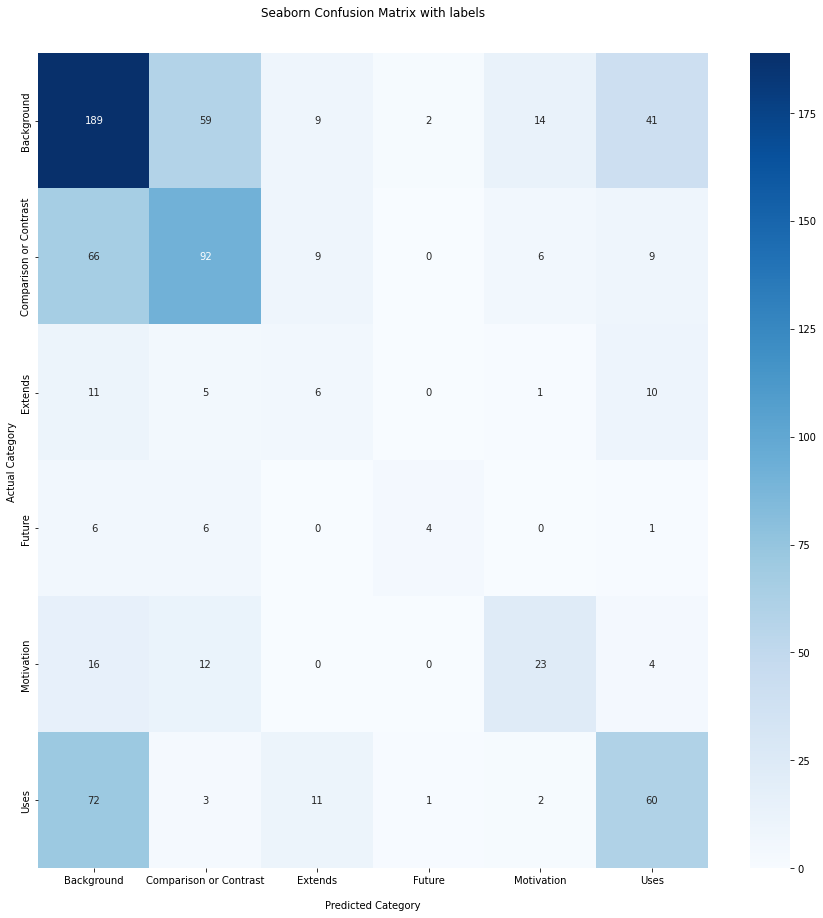

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [233]:
#attention weight of only citeseg vector
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        # print("x.shape")
        # print(x.shape)
        feature_dim = self.feature_dim 
        # print(feature_dim)
        step_dim = self.step_dim
        # print(step_dim)

        eij = torch.mm(x.contiguous().view(-1, feature_dim), self.weight).view(-1, step_dim)
        # print("eij.shape")
        # print(eij.shape)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        #sum= torch.sum(weighted_input, 1)
        return weighted_input

class CitationClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_layers, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
      
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CitationClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_size, hidden_dim,num_layers, bidirectional=True, batch_first=True)
        self.attention_layer = Attention(hidden_dim*2, 193)
        self.fc1 = nn.Linear(hidden_dim*2, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, num_classes)
        self.act=nn.Softmax()
        


    def forward(self, x_in, citseg_id, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batch_size = x_in.size(0)
        seq_length =  x_in.size(1)
        h_embedding = self.emb(x_in)
        # print(h_embedding.shape) 
        packed_output, (hidden, cell) = self.lstm(h_embedding)
        # print(packed_output.shape)
        packed_output = self.attention_layer(packed_output)
        packed_output = packed_output[torch.arange(packed_output.size(0)),citseg_id.long()]
        #h_1h_n=torch.cat([packed_output,packed_output1],dim=1)
        out = self.fc1(packed_output)
        # print(out.shape)
        out = self.relu(out)
        # print(out.shape)
        out = self.fc2(out)
        # print(out.shape)
        pred1= self.act(out)
        # print(pred1.shape)
        return pred1

In [234]:
classifier = CitationClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_layers=args.num_layers,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

print(classifier)

CitationClassifier(
  (emb): Embedding(7632, 300, padding_idx=0)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention_layer): Attention()
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (act): Softmax(dim=None)
)


In [235]:
predictions=[]
prediction=[]
y=[]
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.RMSprop(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()
            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            _, predictions = y_pred.max(dim=1)
            prediction.append(predictions)
            y.append(batch_dict['y_target'])

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_index, running_loss, running_acc))

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        # print("Test loss: {};".format(train_state['val_loss']))
        # print("Test Accuracy: {}".format(train_state['val_acc']))

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


training routine:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	 val_loss=1.790247688293457	 val_acc=24.13333333333333
Epoch 1	 val_loss=1.7761882734298706	 val_acc=30.799999999999997
Epoch 2	 val_loss=1.7475102901458743	 val_acc=12.666666666666666
Epoch 3	 val_loss=1.7436780834198	 val_acc=9.333333333333336
Epoch 4	 val_loss=1.717517213821411	 val_acc=11.200000000000001
Epoch 5	 val_loss=1.716207900047302	 val_acc=10.133333333333333
Epoch 6	 val_loss=1.7059755563735959	 val_acc=23.46666666666667
Epoch 7	 val_loss=1.6832562732696534	 val_acc=31.866666666666667
Epoch 8	 val_loss=1.6908153152465824	 val_acc=30.666666666666668
Epoch 9	 val_loss=1.6931932926177977	 val_acc=23.200000000000003
Epoch 10	 val_loss=1.6661322021484375	 val_acc=34.26666666666666
Epoch 11	 val_loss=1.6669122600555417	 val_acc=35.33333333333333
Epoch 12	 val_loss=1.661072697639465	 val_acc=39.06666666666668
Epoch 13	 val_loss=1.6566308689117433	 val_acc=41.333333333333336
Epoch 14	 val_loss=1.6531094789505	 val_acc=42.13333333333333
Epoch 15	 val_loss=1.6522171592712402

In [236]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
predictions=[]
prediction=[]
y=[]

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],batch_dict['citseg_id'])

    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    _, predictions = y_pred.max(dim=1)
    prediction.append(predictions)
    y.append(batch_dict['y_target'])
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [237]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [238]:
true_y=y_tensor.cpu().detach().numpy()

In [239]:
pred_y=pred_tensor.cpu().detach().numpy()

In [240]:
pred_y=pred_y.flatten()

In [241]:
true_y=true_y.flatten()

In [242]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.53      0.46      0.49       315
Comparison or Contrast       0.38      0.50      0.43       185
               Extends       0.19      0.18      0.19        33
                Future       0.00      0.00      0.00        15
            Motivation       0.51      0.47      0.49        58
                  Uses       0.42      0.43      0.42       144

              accuracy                           0.44       750
             macro avg       0.34      0.34      0.34       750
          weighted avg       0.44      0.44      0.44       750



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

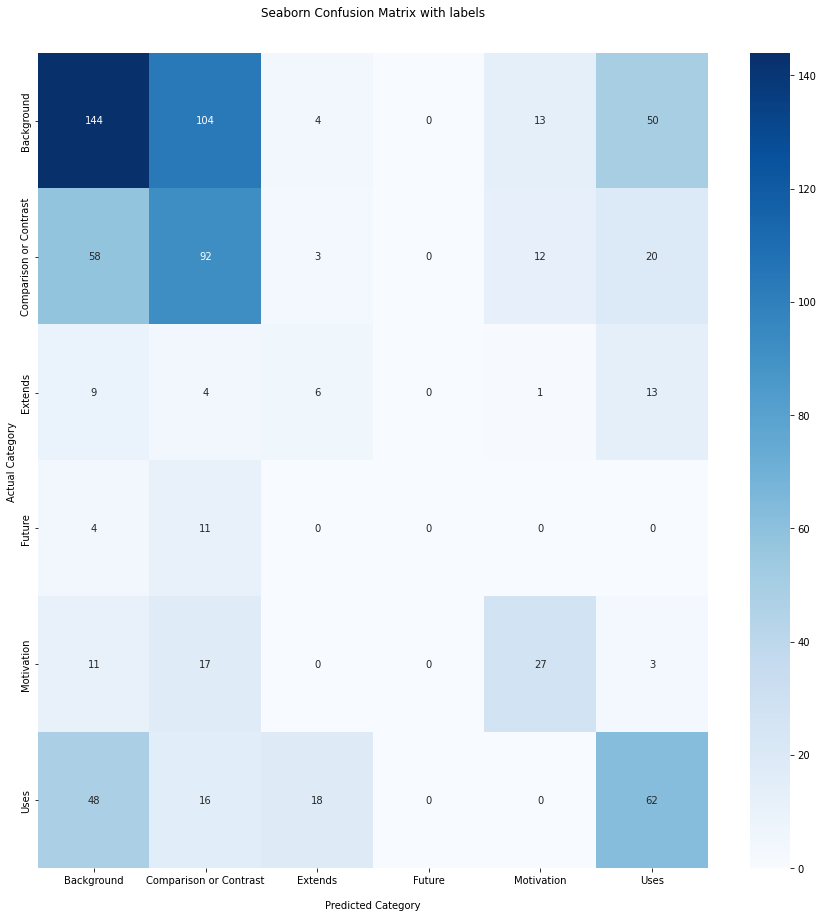

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()